# Implémentation simple d'un ODENet avec Jax

Comme pour les residual networks, on va simplement concaténer plusieurs couches représentant les dynamiques d'EDO.

Commençons par écrire une couche simple. La fonction représentant la dérivée de y(t) sera une couche mlp.

In [7]:
import jax.numpy as jnp

def mlp(params, inputs):
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnp.tanh(outputs)
    return outputs

def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

Il reste donc à combiner cela avec un solver d'EDO pour obtenir le modèle final.

In [8]:
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

Pour que l'on puisse évaluer avec notre ODENet plusieurs inputs en même temps, il faut utiliser une transformation vmap, implémentée dans JAX:

In [9]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

Il nous reste maintenant à faire comme pour le ResNet, c'est-à-dire initialiser les paramètres, définir une loss function et entrainer le réseau.

Text(0, 0.5, 'output')

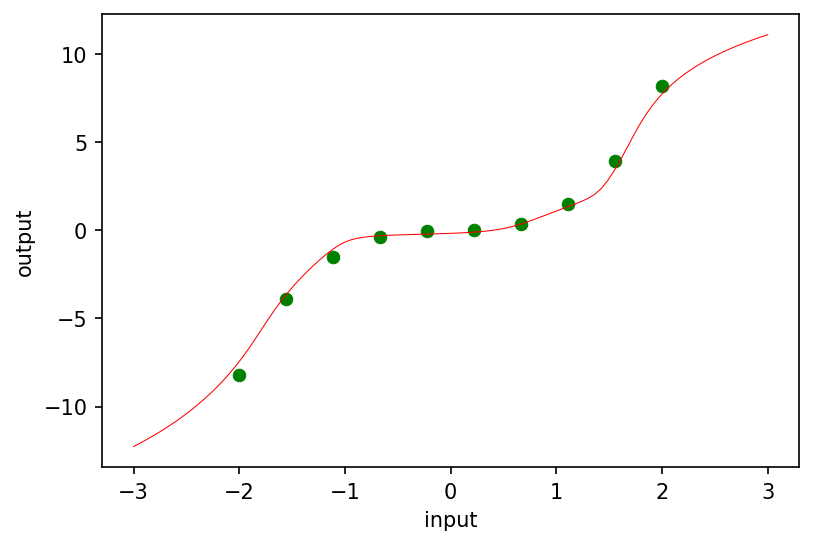

In [12]:
import numpy.random as npr
from jax.api import jit, grad
import matplotlib.pyplot as plt

inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# On doit changer la dimension de l'input à 2 pour permettre des dynamique qui dépendent du temps
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m,n), scale * rng.randn(n)) for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

param_scale = 1
step_size = 0.01
train_iters = 1000

odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
